# Posterior & MAP for the Categorical

**Example**: Weather(W) can be cloudy(C), sunny(S) and rainy(R)

Let, $W \in {C,S,R}$ <br>
Data = {C,S,R,R,S,S,C,R,C,C,S,S,S,S,S,R,S}

What are probabilities of weather to be C, S & R.? <br>
We want to find $\boldsymbol{\theta}$ Which can be in form of vector i.e. (0.2, 0.5, 0.3)


Which distribuion can we assume on $\boldsymbol{\theta}$?

We will use one-hot encoding to present data
\begin{align}
    C &= \begin{bmatrix}
           1 \\
           0 \\
           0
         \end{bmatrix} \\
    S &= \begin{bmatrix}
       0 \\
       1 \\
       0
     \end{bmatrix} \\
    R &= \begin{bmatrix}
       0 \\
       0 \\
       1
     \end{bmatrix} \\
  \end{align}

## Probablistic model

$$
p(\theta \mid D)=\frac{p(D \mid \theta)}{p(D)} p(\theta)
$$

$$
\begin{aligned}
&p(D \mid \theta) \text { - likelihood } \sim Categorical(\boldsymbol{\theta}) \\
&p(\theta) \text { - prior } \sim Dirichlet(\boldsymbol{\alpha}) \\
&p(D) \text { - evidence (data) } \\
&p(\theta \mid D) \text { - posterior } - ????
\end{aligned} 
$$

In [1]:
try:
    import pyro
except ModuleNotFoundError:
    %pip install -qq pyro-ppl
    import pyro
    
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch
    
    
try:
    import tensorflow_probability.substrates.jax as tfp
except ModuleNotFoundError:
    %pip install -qq tensorflow-probability
    import tensorflow_probability.substrates.jax as tfp
    
import jax
import jax.numpy as jnp
rng_key = jax.random.PRNGKey(1)

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax
    
import numpy as np
from rich import print
from rich.table import Table
from collections import Counter

In [2]:
def model(data):
    alpha = pyro.param("alpha", torch.tensor([1.,2.,3.]), constraint=constraints.positive)
    theta = pyro.sample("theta", dist.Dirichlet(alpha))
    with pyro.plate("N", len(data)):
        pyro.sample("W", dist.Categorical(probs=theta) , obs=data)
data = torch.ones(10)

### Probablistic Graphical Model:

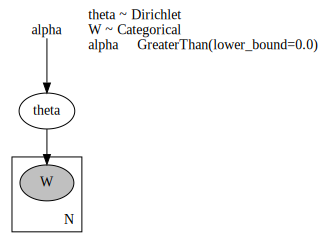

In [3]:
pyro.render_model(model, model_args=(data,), render_distributions=True,render_params=True)

## Programmatically: MLE 

In [4]:
theta_true = [0.5,0.3,0.2] #cloudy = 0.5, sunny = 0.3, rainy = 0.2

In [5]:
weather_one_hot = tfp.distributions.OneHotCategorical(probs=theta_true)
weather_one_hot

<tfp.distributions.OneHotCategorical 'OneHotCategorical' batch_shape=[] event_shape=[3] dtype=int32>

In [6]:
nsamples = 365
dataset = weather_one_hot.sample(nsamples, seed=rng_key)
dataset[:5]

/home/patel_zeel/miniconda3/envs/py3713_2/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


DeviceArray([[1, 0, 0],
             [0, 1, 0],
             [0, 1, 0],
             [0, 1, 0],
             [1, 0, 0]], dtype=int32)

In [7]:
def neg_log_likelihood(theta):
    theta = jax.nn.softmax(theta) 
    log_likelihood = tfp.distributions.OneHotCategorical(probs=theta).log_prob(dataset).sum()
    return -log_likelihood

In [8]:
grad_loss = jax.grad(neg_log_likelihood)
grad_loss(jnp.array(theta_true)) #sanity check

DeviceArray([-42.396763 ,   2.7536752,  39.643093 ], dtype=float32)

In [9]:
optimizer = optax.sgd(learning_rate=0.001)
theta = jnp.array([0.2,0.6,0.4])
opt_state = optimizer.init(theta)
opt_state

(EmptyState(), EmptyState())

In [10]:
#https://code-first-ml.github.io/book1/notebooks/introduction/mle_coin.html
table = Table(title="MLE Convergence")

table.add_column("Iteration", justify="right", style="cyan", no_wrap=True)
table.add_column("Loss", justify="right", style="magenta")
table.add_column("Theta", justify="right", style="green")

In [11]:
n_ierations = 50
for i in range(n_ierations+1):
    cost_val = neg_log_likelihood(theta)
    if i%5 == 0:
        table.add_row(str(i), f"{cost_val:0.2f}", f"{jax.nn.softmax(theta)}")
    grad_theta_val = grad_loss(theta)
    updates, opt_state = optimizer.update(grad_theta_val, opt_state)
    theta = optax.apply_updates(theta, updates)
print(table)

                      MLE Convergence                      
┏━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Iteration ┃   Loss ┃                              Theta ┃
┡━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         0 │ 420.04 │ [0.2693075  0.40175956 0.3289329 ] │
│         5 │ 384.57 │ [0.38072824 0.354583   0.2646888 ] │
│        10 │ 374.89 │ [0.44396126 0.3276724  0.22836639] │
│        15 │ 372.34 │ [0.4756222  0.3157025  0.20867527] │
│        20 │ 371.62 │ [0.49108076 0.31122136 0.19769795] │
│        25 │ 371.39 │ [0.4986738  0.31000355 0.19132262] │
│        30 │ 371.31 │ [0.5024727  0.3100439  0.18748337] │
│        35 │ 371.28 │ [0.50442356 0.3104709  0.18510553] │
│        40 │ 371.26 │ [0.5054576  0.31094012 0.18360236] │
│        45 │ 371.26 │ [0.50602496 0.31133685 0.18263823] │
│        50 │ 371.25 │ [0.5063474  0.31163898 0.18201359] │
└───────────┴────────┴────────────────────────────────────┘

Analyical $\theta$_MLE:
\begin{align}
        \theta_c &= \frac{N_c}{n}
\end{align}
Where $N_c$ is number of obeservations of label c 

In [12]:
count = Counter([tuple(np.array(a)) for a in dataset])
count

Counter({(1, 0, 0): 185, (0, 1, 0): 114, (0, 0, 1): 66})

In [13]:
count_per_label = jnp.array(list(count.values()),dtype=np.float16)
count_per_label

DeviceArray([185., 114.,  66.], dtype=float16)

In [14]:
theta_mle_analytical = count_per_label/nsamples
theta_mle_analytical

DeviceArray([0.507 , 0.3123, 0.1808], dtype=float16)

## Programmatically: MAP

In [15]:
alphas = jnp.array([30.,60.,20.])
def neg_log_prior(theta):
    theta = jax.nn.softmax(theta)
    log_prior = tfp.distributions.Dirichlet(concentration=alphas).log_prob(theta)
    return -log_prior
    
def neg_log_prob(theta):
    return neg_log_likelihood(theta) + neg_log_prior(theta)

In [16]:
grad_loss = jax.grad(neg_log_prob)
grad_loss(jnp.array(theta_true)) #sanity check

DeviceArray([-29.592524, -22.019915,  51.612434], dtype=float32)

In [17]:
optimizer = optax.sgd(learning_rate=0.0009)
theta = jnp.array([0.2,0.2,0.4])
opt_state = optimizer.init(theta)
opt_state

(EmptyState(), EmptyState())

In [18]:
table = Table(title="MAP Convergence")

table.add_column("Iteration", justify="right", style="cyan", no_wrap=True)
table.add_column("Loss", justify="right", style="magenta")
table.add_column("Theta", justify="right", style="green")

In [19]:
n_ierations = 50
for i in range(n_ierations+1):
    cost_val = neg_log_prob(theta)
    if i%5 == 0:
        table.add_row(str(i), f"{cost_val:0.2f}", f"{jax.nn.softmax(theta)}")
    grad_theta_val = grad_loss(theta)
    updates, opt_state = optimizer.update(grad_theta_val, opt_state)
    theta = optax.apply_updates(theta, updates)
print(table); print(f"True alpha: {alphas}") ;print(f"True theta: {theta_true}")

                      MAP Convergence                      
┏━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Iteration ┃   Loss ┃                              Theta ┃
┡━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         0 │ 424.66 │ [0.31042376 0.31042376 0.37915242] │
│         5 │ 389.92 │ [0.38767618 0.3378548  0.27446902] │
│        10 │ 381.64 │ [0.42200914 0.34818852 0.22980233] │
│        15 │ 379.29 │ [0.43755588 0.35448363 0.20796049] │
│        20 │ 378.54 │ [0.4449594  0.35875818 0.19628237] │
│        25 │ 378.28 │ [0.4486969  0.36160967 0.18969342] │
│        30 │ 378.19 │ [0.4506897  0.36345574 0.18585457] │
│        35 │ 378.16 │ [0.4518006  0.3646248  0.18357462] │
│        40 │ 378.15 │ [0.45244056 0.36535472 0.18220481] │
│        45 │ 378.14 │ [0.4528175  0.3658065  0.18137605] │
│        50 │ 378.14 │ [0.45304283 0.36608472 0.18087253] │
└───────────┴────────┴────────────────────────────────────┘

True alpha: [30. 60. 20.]

True theta: [0.5, 0.3, 0.2]

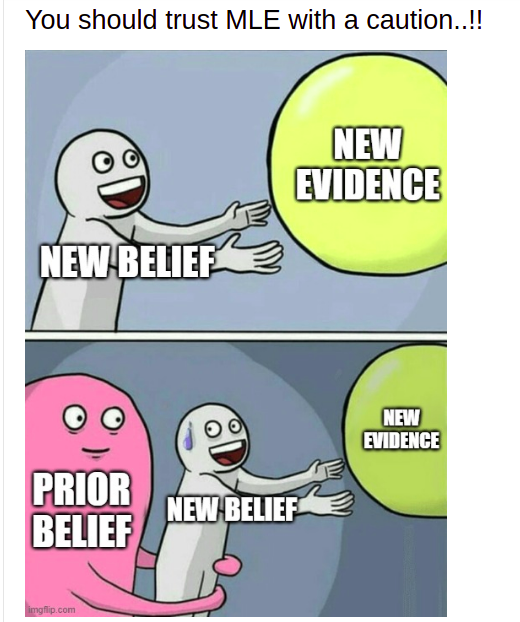

## Analyical  𝜃 _map

Analyical $\theta$_map

**Posterior**:
$$
\begin{aligned}
p(\theta \mid D) &=\frac{p(D \mid \theta) p({\theta})}{p(D)} \\
&\sim p(D \mid {\theta}) \cdot p ({\theta}) \\
&\sim p({\theta}) \cdot \prod_{i=0}^{D-1} p\left(W=w^{i} \mid {\theta}\right)\\
& \sim \prod_{d=0}^{D-1} \theta_{d}^{\alpha_{d}-1} \prod_{d=0}^{D-1} \prod_{i=0}^{k-1} \theta_{d}^{I(w^{c_{i}=d})} \\
& \sim \prod_{d=0}^{D-1} \theta_{d}^{\alpha_{d}+ N_{d} -1} \\ 
\end{aligned} 
$$
Here Dirichlet prior is conjugate to categorical likelihood!

**MAP**<br>
For dirichlet distribution,
$$
x_{mode_{i}}=\frac{\alpha_{i}-1}{\sum_{k=1}^{K} (\alpha_{k}-1)}
$$

In our case,
$$
\theta_{MAP_{d}}=\frac{\alpha_{d}+N_{d}-1}{\sum_{k=1}^{K}  (N_{d}+ \alpha_{k}-1)}
$$

In [20]:
theta_map_analytical = (alphas + count_per_label - 1.0)/(nsamples + alphas.sum() - 3)
theta_map_analytical

DeviceArray([0.45338982, 0.3665254 , 0.18008475], dtype=float32)